## Example of Trans-C sampling across independent model states

This notebook demonstrates sampling across unormalized multi-dimensional Gaussian PDFs in states with non-consequtive dimensions
using the Pseudo-Prior sampler.

In [1]:
# general python utility packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from tqdm import tqdm
import corner
import time
from collections import Counter
from matplotlib.ticker import MaxNLocator
import pickle as pickle
from scipy.optimize import minimize

#### TransC class

In [2]:
from pyTransC import TransC_Sampler

In [3]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

--------

## Example set up: Three states with non-consecutive dimensions, 3D, 5D and 10D Gaussians

Set some global control parameters for all examples.

In [4]:
plotting = True      # Create some diagnostic displays of outputs
parallel = False     # Use parallel computation for sampling
autopseudo = True    # Use automatic generation of pseudo-prior function, as alternate to user specified Gaussian.
autothin = False     # Thin internally generated within state posterior ensembles by their auto-correlation 
                     # (This can take additional compute time, and is not necessary if input ensembles are already independent.)

Define log posterior PDF for three states with Gaussian posterior PDF.

First we set up three unormalized Gaussian states.

In [5]:
# Set up PDFs in each state
nstates = 3                                      # Number of states
ndims = [3,5,10]                                 # Number of dimensions for each state
weights = [0.56,0.3,0.14]                        # weights for each state (become true values for relative evidence/marginal Likelihoods.
trueML = weights/np.sum(weights)                 # true values of marginal Likelihoods/relative evidences
mu = [[0.8,0.8,0.8],[0.3 for i in range(5)],[0.5 for i in range(10)]] # Gaussian means for each state
sig = [0.02,0.05,0.08]                           # standard deviations of Gaussians in each state
cov = [np.diag(np.ones(ndims[i])*sig[i]**2) for i in range(nstates)] # covariance matrices for each state
if(True):                                        # rotate the covariance matrices
    np.random.seed(210165)
    new_cov = []
    for i in range(nstates):
        rotation_matrix = np.random.rand(ndims[i],ndims[i])-0.5
        new_cov.append(rotation_matrix @ cov[i] @ rotation_matrix.T)
    cov = new_cov
icov = [1./cov[0],np.linalg.inv(cov[1]),np.linalg.inv(cov[2])] # inverse covariance matrices for each state

### Log-posteripr PDF
Define log_posterior function using these Gaussian PDFs.

In [6]:
def log_posterior(x,state,ndims,mu,cov,weights,icov=False): # Multi-state log Posterior PDF evaluation (unormalised) for three multi-dimensional Gaussians
    w = weights[state]
    mean = mu[state]
    covar = cov[state]
    r = mean-x 
    if(icov):
        if(ndims[state] == 1): 
            log_const = np.log(w) - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(covar[0])
            out = log_const-0.5 * np.dot(r,r)*(covar[0])
        else:
            log_const = np.log(w) - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(covar)) 
            out = log_const-0.5 * np.dot(r, np.dot(covar, r))
    else:
        if(ndims[state] == 1): 
            log_const = np.log(w) - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(covar[0])
            out = log_const-0.5 * np.dot(r,r)/(covar[0])
        else:
            log_const = np.log(w) - 0.5*len(x)*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(covar)) 
            out = log_const-0.5 * np.dot(r, np.linalg.solve(covar, r))
    return out
    
log_posterior_args = [ndims,mu,cov,weights]

### Starting points for MCMC samplers

In [7]:
# first we optimize each state to find good starting point for all McMC samplers
np.random.seed(42)
if(True):
    nll = lambda *args: -log_posterior(*args)
    initial = np.array([0.5])
    ml = []
    print("Maximum likelihood estimates:")
    for i in range(nstates):
        soln = minimize(nll, initial, args=(i,ndims,mu,cov,weights))
        ml.append(soln.x)
        print("x_ml = {0:.3f}".format(soln.x[0]))

Maximum likelihood estimates:
x_ml = 0.800
x_ml = 0.300
x_ml = 0.500


### Decide on normalized pseudo prior PDFs

Here we demonstrate how to define a pseudo_prior PDF, by either

    - fitting a mixture model approximation to existing ensembles (autopseudo=True),

    - defining a Gaussian within each state (autopseudo=False)

Our implementation of an automatic pseudo prior function, uses the supplied class function `build_pseudo_prior`.  This class function is essentially a wrapper routine around calls to `run_mcmc_per_state` and `run_fitmixture`, similar to the pre calculation below for `run-ens-sampler`. To encourage independence of samples produced `run_mcmc_per_state`, the ensembles input to `run_fitmixture` are thinned using the Markov chain correlation times calculated for each state.

Use of `autothin=True` means that auto correlation times are calculated for each space and the ensembles used to construct pseudo_priors are thinned by this value. This slows down the procedure because the auto correlation calculation is relatively slow.

In truth the question of how to build a normalized PDF approximation of the posterior (for use as a pseudo-prior) is an open question, and so `build_pseudo_prior` should be taken as a simple example implementation of this.

In [8]:
if(autopseudo): # Automatic pseudo prior function
    nwalkers_auto = 32                                                # Number of walkers for auto pseudo prior fitting
    nsteps_auto = 1000                                               # Number of chain steps for auto pseudo prior fitting
    pos_states = np.random.choice(np.arange(nstates),nwalkers_auto) # Initial states of each walker for auto pseudo prior fitting
    pos = []
    for i in range(nstates): # generate starting points for each chain in each state
        pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers_auto, ndims[i])) # add random perturbation to maximum Likelihood models
    
    tcs = TransC_Sampler(nstates,ndims) # create instances of states
    auto_log_pseudo_prior = tcs.build_auto_pseudo_prior(pos,log_posterior,log_posterior_args=log_posterior_args,
                                                   nwalkers=nwalkers_auto,nsamples=nsteps_auto,autothin=autothin,parallel=parallel)

    log_pseudo_prior_args = []   # additional argument list beyond (x,state) for log_pseudo_prior function

    def log_pseudo_prior(x,state,returndeviate=False):               # multi-state log pseudo-prior density and deviate generator
        return auto_log_pseudo_prior(x,state,returndeviate=returndeviate)

else:  # A Gaussian pseudo prior within each model state

    def log_pseudo_prior(x,state,ndims,returndeviate=False):               # multi-state log pseudo-prior density and deviate generator
        mu = [[0.6],[0.7,0.7,0.7],[0.2,0.2,0.2,0.2,0.2]]                   # Gaussian means for each state
        sig = [0.025,0.055,0.085]                                          # standard deviations of isotropic Gaussians in each state
        cov = [np.array([sig[0]**2]),np.diag(np.ones(ndims[1])*sig[1]**2),
                np.diag(sig[2]**2*np.ones(ndims[2]))]                       # covariance matrices for each state
        if(returndeviate):
            x = stats.multivariate_normal.rvs(mean=mu[state],cov=cov[state]) # spherical multi-dimensional Gaussian
            logppx = stats.multivariate_normal.logpdf(x,mean=mu[state],cov=cov[state]) # spherical multi-dimensional Gaussian
            if(type(x) != np.ndarray): x = np.array([x]) # deal with 1D case which returns a scalar
            return logppx,x
        else:
            return stats.multivariate_normal.logpdf(x,mean=mu[state],cov=cov[state]) # spherical multi-dimensional Gaussian 

    log_pseudo_prior_args = [ndims]   # additional argument list beyond (x,state)    

-----------

Now we are ready to apply the three algorithms to sampling over the model states.

## Trans-C samping across model states with algorithm 2: The Pseudo sampler 

Here we demonstrate use of the *Pseudo-prior sampler*.

This formulation is equivalent to the product space algorithm with the proposal for the other state variables equal to the pseudo-prior, for which moves are then accepted with probability one. As a consequence  the only pair of model states that need be considered is the k and k' states (i.e. same as in RJ-transD). 

- For within-state moves the acceptance is the usual M-H condition with proposal = to users choice for that state, defined by routine `log_proposal`
  This can be any perturbative proposal PDF designed by the user, or an automatic one found by fitting a Gaussian mixture model to some trial samples, which is performed by the class function `build_pseudo_prior`.

- For between-state moves we assume that only the state index changes, k -> k', and hence the model in state k' must be a draw from the pseduo prior for that state. The acceptance term then only involves the likelihood ratio and the pseudo-prior ratio for the two states.


In [9]:
# define model proposal for each state
def log_proposal(xc,state,ndims):  # defines a pseudo-prior of an isotropic Gaussian in dimension of input point

    use_pseudo_prior = True
    use_pseudo_prior = False
    if(use_pseudo_prior):  # use the pseudo-prior in each state as the proposal distribution
        lpseudop, pmodel = auto_log_pseudo_prior(None,state,returndeviate=True)  # generate deviate from pseudo prior in current state
        lpseudoc = auto_log_pseudo_prior(xc,state)                               # log pseudo-prior of current chain model
        logpert = lpseudoc - lpseudop  # log difference in pseduo-priors
        return logpert,pmodel
    else:                                # use a symmetric Gaussian in each state as the proposal distribution
        sig = [0.04,0.04,0.04]           # Gaussian centred on current chain location
        cov = [np.diag(np.ones(ndims[i])*sig[i]**2) for i in range(nstates)] # covariance matrices for each state

        x = xc + stats.multivariate_normal.rvs(mean=np.zeros(ndims[state]),cov=cov[state]) # spherical multi-dimensional Gaussian
        logpert = 0.0 # log ratio for symmetric proposal
        if(type(x) != np.ndarray): x = np.array([x]) # deal with 1D case which returns a scalar
        return logpert,x # return log of pseudo prior density and location (as 1D array)
    
log_proposal_args = [ndims]    # additional argument list beyond (x,state)

In [10]:
# perform initiation of IS-sampler
tcs2 = TransC_Sampler(nstates,ndims) # create instances of states

In [11]:
# pseudo prior proposal algorithm set up
nwalkers_pp = 32                                               # Number of walkers for product space
nsteps_pp = 100000                                              # Number of chain steps for product space
pos_states = np.random.choice(np.arange(nstates),nwalkers_pp)  # Initial states of each walker
pos = []
for i in range(nwalkers_pp): # generate starting points for each walker
    pos.append(ml[pos_states[i]] + 1e-4 * np.random.randn(ndims[pos_states[i]])) # add random perturbation to maximum Likelihood models

In [12]:
start_time = time.time()
tcs2.run_pseudo_sampler(nwalkers_pp,
                 nsteps_pp,
                 pos,
                 pos_states,
                 log_posterior,
                 log_pseudo_prior,
                 log_proposal,
                 log_posterior_args=log_posterior_args,
                 log_pseudo_prior_args=log_pseudo_prior_args,
                 log_proposal_args=log_proposal_args,
                 parallel=parallel,
                 progress=True)
elapsed_time = time.time() - start_time


Running pseudo-prior trans-D sampler

Number of walkers               :  32
Number of states being sampled  :  3
Dimensions of each state        :  [3, 5, 10]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [04:39<00:00,  8.74s/it]


In [13]:
# print some diagnostics
key = tcs2
print('\n Algorithm type                                   :', key.alg)
# extract trans-D samples and chains
discard = 0                  # chain burnin
thin = 15                    # chain thinning
thin = 1                    # chain thinning
chain,states_chain = key.get_visits_to_states(discard=discard,thin=thin,normalize=True,walker_average='median',return_samples=True)

print(' Total number of state changes for all walkers    :',key.total_state_changes)
print(' Number of state changes for each walker          :\n',*key.state_changes_perwalker)
print(' Acceptance rates for walkers within states:  \n',key.accept_within_per_walker,'\n')
print(' Acceptance rates for walkers between states: \n',key.accept_between_per_walker,'\n')
print(' Average % acceptance rate for within states      :',np.round(key.accept_within,2))
print(' Average % acceptance rate for between states     :',np.round(key.accept_between,2))
print(' Auto correlation time for between state sampling :',np.round(key.autocorr_time_for_between_state_jumps,3))
print(' True relative marginal Likelihoods               :', trueML)
print(' Estimated relative evidences                     :', key.relative_marginal_likelihoods)
print(' Elapsed time.                                    :', np.round(elapsed_time,2),'s \n')


 Algorithm type                                   : TransC-pseudo-sampler
 Total number of state changes for all walkers    : 171775
 Number of state changes for each walker          :
 5236 5391 5340 5279 5256 5468 5419 5396 5293 5207 5503 5453 5439 5402 5294 5549 5343 5240 5458 5394 5472 5311 5380 5314 5321 5448 5380 5350 5382 5348 5412 5297
 Acceptance rates for walkers within states:  
 [0.01090299 0.01130955 0.01073178 0.01073405 0.01130621 0.01143589
 0.01086002 0.01082836 0.01117157 0.01077916 0.01117461 0.01067105
 0.01107101 0.01091851 0.01070452 0.01097057 0.01105193 0.01056487
 0.01055617 0.01152821 0.01061061 0.01080625 0.01094542 0.01056805
 0.01065863 0.0104184  0.01061666 0.01110951 0.01026457 0.01065994
 0.01062944 0.01085388] 

 Acceptance rates for walkers between states: 
 [0.52713178 0.53503374 0.5346951  0.52758345 0.52765787 0.53634134
 0.53990236 0.536862   0.5319598  0.53002239 0.54680048 0.54328983
 0.54690799 0.53692476 0.5273959  0.55312998 0.54078947 0.5299

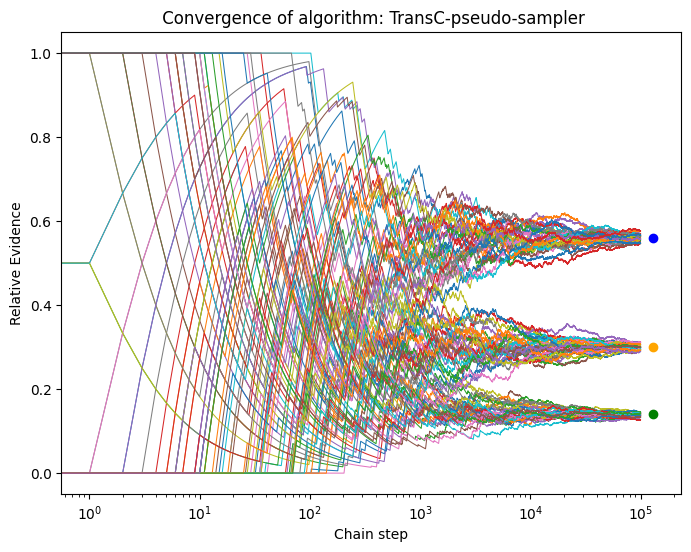

In [14]:
# plot relative number of visit to each state along the chain
if(plotting):
    fig, axes = plt.subplots(figsize=(8,6))
    if(chain.ndim == 3): # plot chains for each state and walker
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75)
    elif(chain.ndim==2): # plot chains for each state average over walkers
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75,label=['State 1','State 2','State 3'])
        plt.legend()
    plt.xlabel('Chain step')
    plt.ylabel('Relative Evidence')
    plt.plot(len(chain)*1.3,trueML[0],'bo')
    plt.plot(len(chain)*1.3,trueML[1],'o',color='orange')
    plt.plot(len(chain)*1.3,trueML[2],'go')
    plt.title(' Convergence of algorithm: '+key.alg)
    #plt.savefig('convergence_pseudo_3-5-10.pdf')
    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains of the Product-space sampler are 
converging, and visiting each state in proportion to the correct normalization constant. 

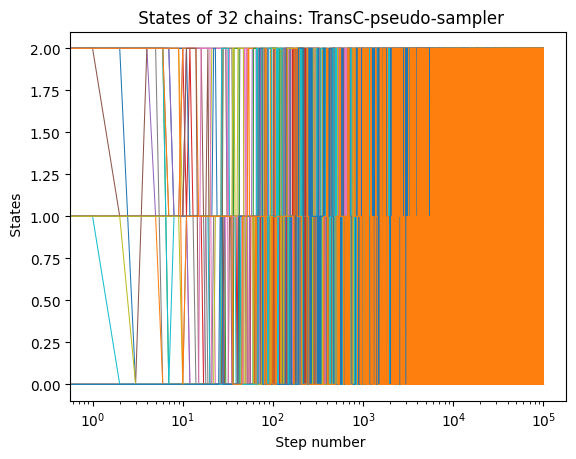

In [15]:
# plot chain states
if(plotting):
    # plot chains for each state and walker
    plt.semilogx(states_chain.reshape(np.shape(states_chain)[0],-1),lw=0.75)
    plt.xlabel(' Step number')
    plt.ylabel(' States')
    title = ' States of '+str(nwalkers_pp)+' chains: '+key.alg
    plt.title(title)
    #plt.savefig('convergence.pdf')
    plt.show()

This plot shows the movement of each chain between states.

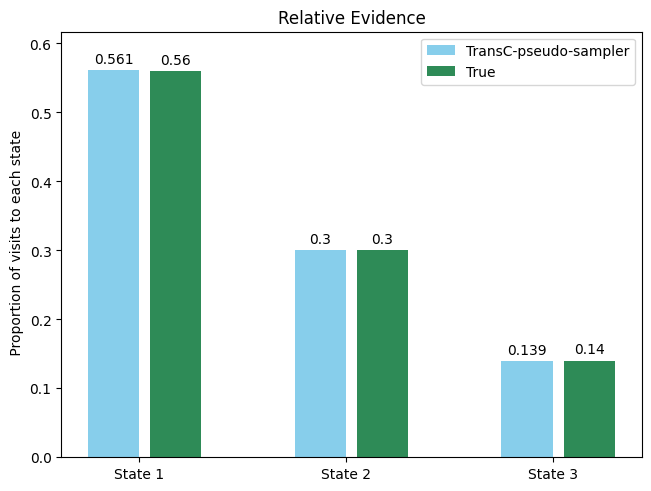

In [16]:
# Count visits to each state by Trans-D mcmc
if(plotting):
    h=np.zeros(key.nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(Counter(states_chain.reshape(-1)).values())
    h/=np.sum(h)

    # plot histogram of frequency of visits to each state

    labels = ("State 1", "State 2", "State 3")
    labels = ['State '+str(i+1) for i in np.arange(nstates)]

    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h,3), width, label=key.alg,color='skyblue')
    #rects = ax.bar(x + offset, np.round(h,3), width, label='Trans-D',color='lightcoral')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier+0.05
    rects = ax.bar(x + offset, np.round(trueML,3), width, label='True',color='seagreen')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(' Proportion of visits to each state')
    ax.set_title('Relative Evidence')
    ax.set_xticks(x + width/2, labels)
    ax.legend(loc='upper right')
    ax.set_ylim(0.,np.max(np.maximum(h,trueML))*1.1)
    #plt.savefig('Marginal_Likelihoods.png')
    plt.show()

 State;  0  in  3  dimensions
 State;  1  in  5  dimensions
 State;  2  in  10  dimensions


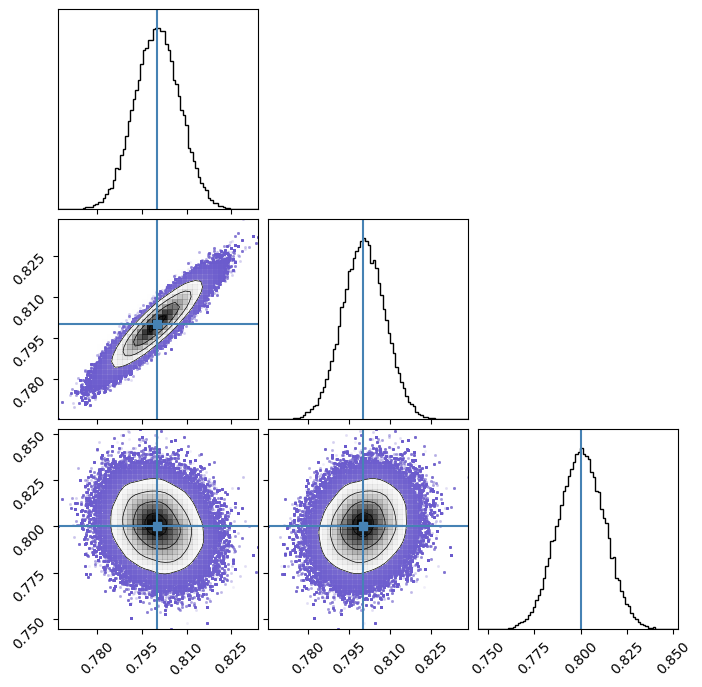

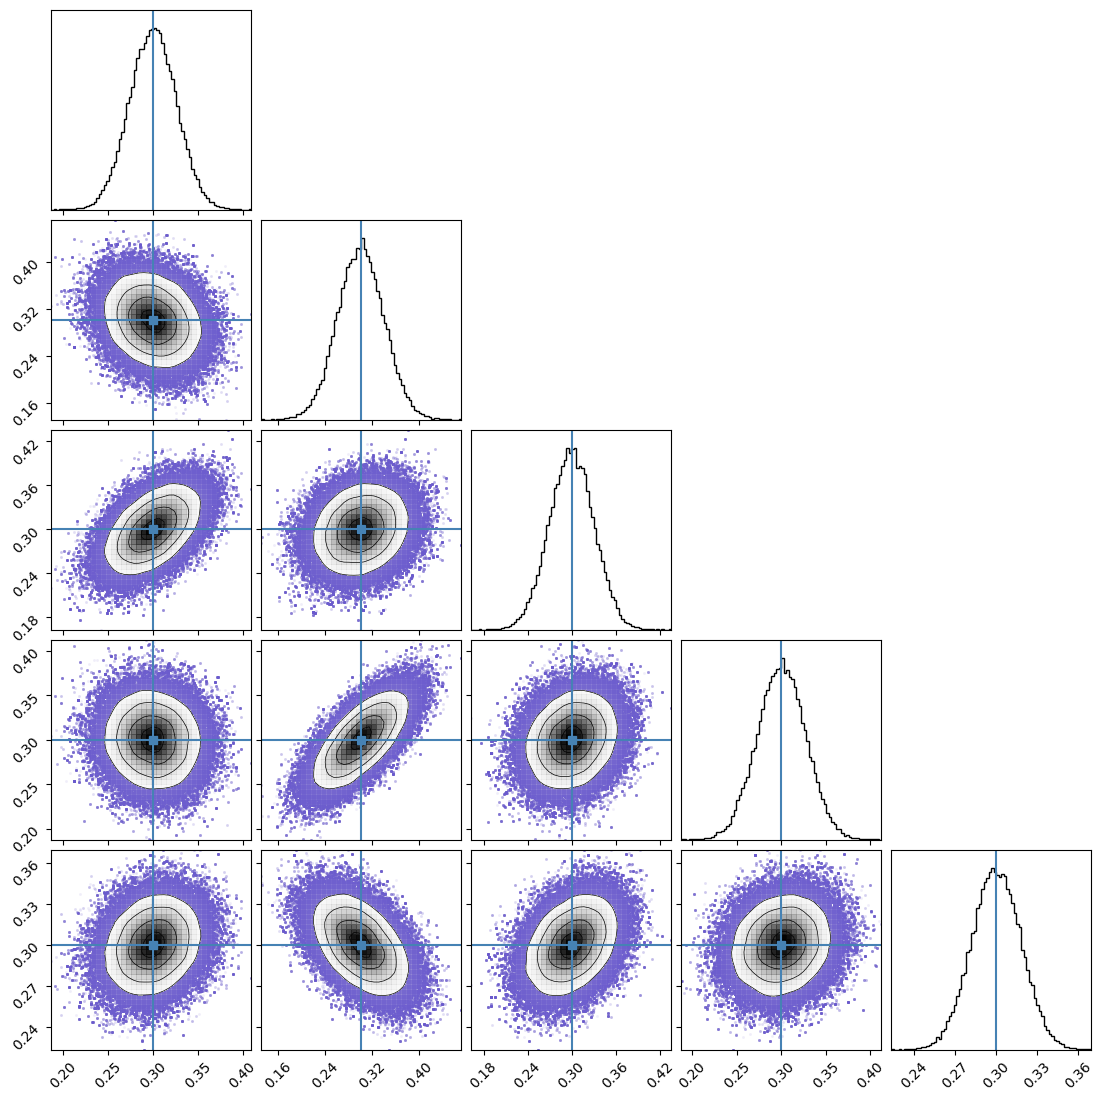

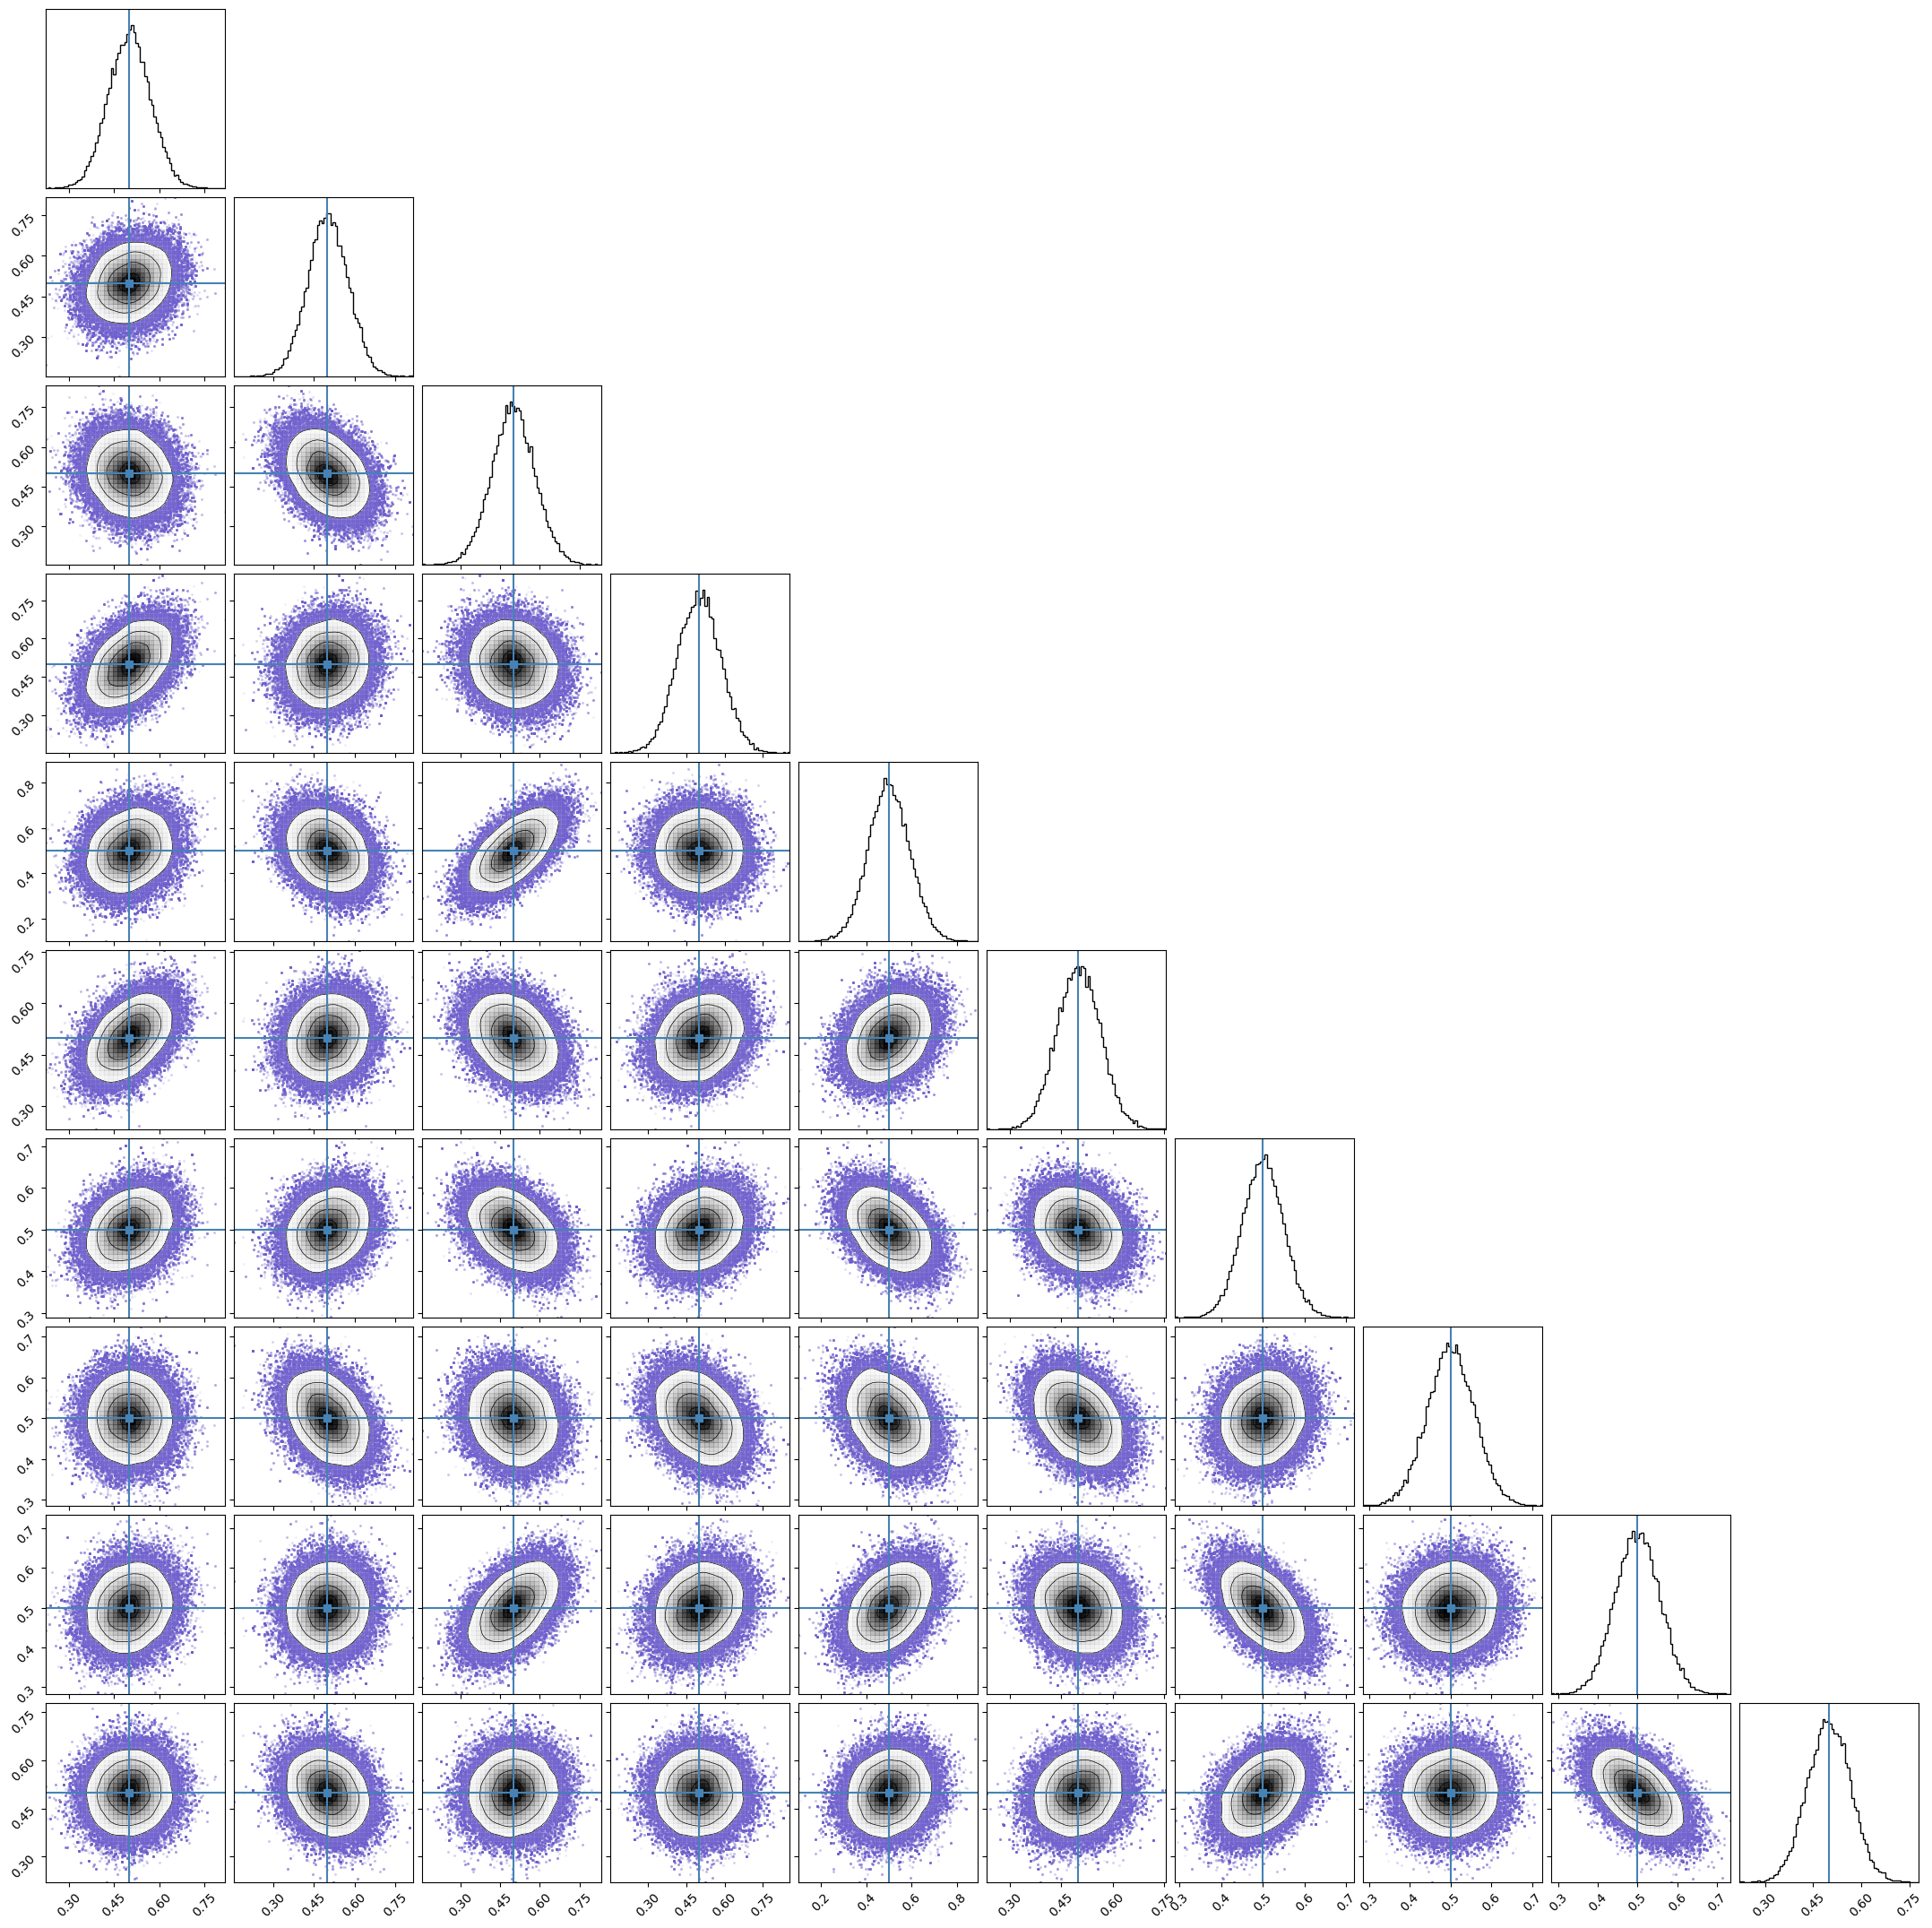

In [17]:
# corner plots to check sampling within each state
if(plotting):
    # collect trans samples
    transc_ensemble,model_chain,states_chain = key.get_transc_samples(discard=0,thin=thin,flat=True,returnchains=True)
    contour_kwargs = {"linewidths" : 0.5}
    data_kwargs = {"color" : "slateblue"}
    for i in range(nstates):
        string = 'State '+str(i)
        print(' State; ',i,' in ',ndims[i],' dimensions')
        fig = corner.corner(
            flatten_extend(transc_ensemble[i]).reshape(-1,ndims[i]), 
            truths=mu[i],
            title=string,
            bins=40,hist_bin_factor=2,smooth=True,contour_kwargs=contour_kwargs,data_kwargs=data_kwargs
            );

Sampling within each state looks reasonable. 

In [18]:
print(' Here is the Trans-C ensemble with\n {} samples in state 1\n {} samples in state 2\n {} samples in state 3\n'
      .format(len(transc_ensemble[0]),len(transc_ensemble[1]),len(transc_ensemble[2])),'\n',transc_ensemble)

 Here is the Trans-C ensemble with
 1795365 samples in state 1
 959757 samples in state 2
 444878 samples in state 3
 
 [array([[0.81153358, 0.81322225, 0.80685263],
       [0.81153358, 0.81322225, 0.80685263],
       [0.81153358, 0.81322225, 0.80685263],
       ...,
       [0.79705622, 0.79731813, 0.79677542],
       [0.79705622, 0.79731813, 0.79677542],
       [0.79705622, 0.79731813, 0.79677542]], shape=(1795365, 3)), array([[0.30281178, 0.29962123, 0.29400276, 0.25432357, 0.26724015],
       [0.30281178, 0.29962123, 0.29400276, 0.25432357, 0.26724015],
       [0.30281178, 0.29962123, 0.29400276, 0.25432357, 0.26724015],
       ...,
       [0.26786173, 0.28075991, 0.2720434 , 0.27853212, 0.28443992],
       [0.26786173, 0.28075991, 0.2720434 , 0.27853212, 0.28443992],
       [0.26786173, 0.28075991, 0.2720434 , 0.27853212, 0.28443992]],
      shape=(959757, 5)), array([[0.50006434, 0.50015647, 0.5001205 , ..., 0.49995297, 0.49995975,
        0.49995709],
       [0.50006434, 0.500156

---------

### Example of using Laplace approximation

Here is an example of using the Laplace approximation to calculate evidence for each state using log-posterior function and guessed MAP models.

In [19]:
MAP_guess = [np.array([0.0 for i in range(3)]),
      np.array([0.0 for i in range(5)]),
      np.array([0.0 for i in range(10)])] # starting points for MAP optimization in each state (even though we actually know the MAP models!)

In [28]:
tcs2.run_laplace_evidence_approximation(
    log_posterior,
    MAP_guess,
    log_posterior_args=log_posterior_args,
    optimize=True)
tot = np.sum(np.exp(tcs2.log_marginal_likelihoods_laplace))
print(' Estimated relative evidences                        :', *np.round((np.exp(tcs2.log_marginal_likelihoods_laplace))/tot,8))
print(' MAP models per state from optimization              ')
for i in range(3):
    print(' State              ',i,':',tcs2.laplace_map_models_per_state[i])

 Estimated relative evidences                        : 0.56 0.3 0.14
 MAP models per state from optimization              
 State               0 : [0.79999951 0.79999949 0.79999997]
 State               1 : [0.29999991 0.29999987 0.30000007 0.29999971 0.29999994]
 State               2 : [0.49999919 0.49999981 0.49999897 0.49999913 0.49999914 0.50000036
 0.50000029 0.4999995  0.49999841 0.50000065]
